# PDE-FIND za valnu jednadžbu

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE_FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku valnog gibanja za c=2.
$$
u_{t} - cu_{x} = 0
$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys; sys.path.append('../')
from PDE_FIND_QM import *

# Stvaranje podataka:

Stvaramo podatke koji će biti korišteni u identifikaciji jednadžbe gibanja.

In [2]:
x = np.linspace(0,20,100)
dx = x[2]-x[1]
t = np.linspace(0,5,100)
dt = t[1]-t[0]
u = np.zeros((len(x),len(t)))
c=2
for i in range(len(x)):
    for j in range(len(t)):
        u[i,j] = np.cos(x[i]/c-t[j]) # valna funkcija u(x,t)

Text(0.5, 0.5, 't')

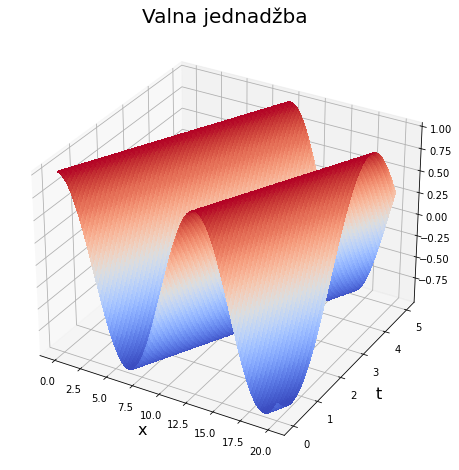

In [3]:
X, T = np.meshgrid(x, t)
fig1 = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
plt.title('Valna jednadžba', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('t', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Funkcija build_linear_system to radi za nas. Specificiramo <br>
D = najviši red derivacije koja će se se nalaziti u $\Theta$  <br>
P = najviši red polinoma od $u$ koji će se nalaziti u $\Theta$ (ne računajući umnoške s derivacijama.  <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [5]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, rhs_des)

PDJ dobivena pomoću STRidge:
u_t = (-2.002414 -0.000000i)u_{x}
   


In [6]:
err = abs(np.array([(2 -  2.002414)/2*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike:\n")
print(np.mean(err), '%')
#print("Srednja greška parametara:", np.mean(err), '%')
#print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike:

0.12069999999999581 %


## Identificiramo istu dinamiku ali sa dodanim šumom na podatcima:

Jedina razlika od primjera gore je da metoda konačnih razlika ne radi dobro za podatke sa šumom pa koristimo polinomijalnu interpolaciju. Sa deg_x ili deg_t i width_x i width_t određujemo stupanj polinoma i broj točaka za deriviranje po x i t. Nažalost, rezultati mogu biti osjetljivi na ove veličine.

In [7]:
np.random.seed(0)
un = u + 0.01*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

In [8]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)

In [9]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, rhs_des)

PDJ dobivena pomoću STRidge:
u_t = (-2.004442 +0.000000i)u_{x}
   


In [10]:
err = abs(np.array([(2 -  2.004442)/2*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print(np.mean(err), '%')
#print("Srednja greška parametara:", np.mean(err), '%')
#print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

0.22210000000000285 %
